In [4]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


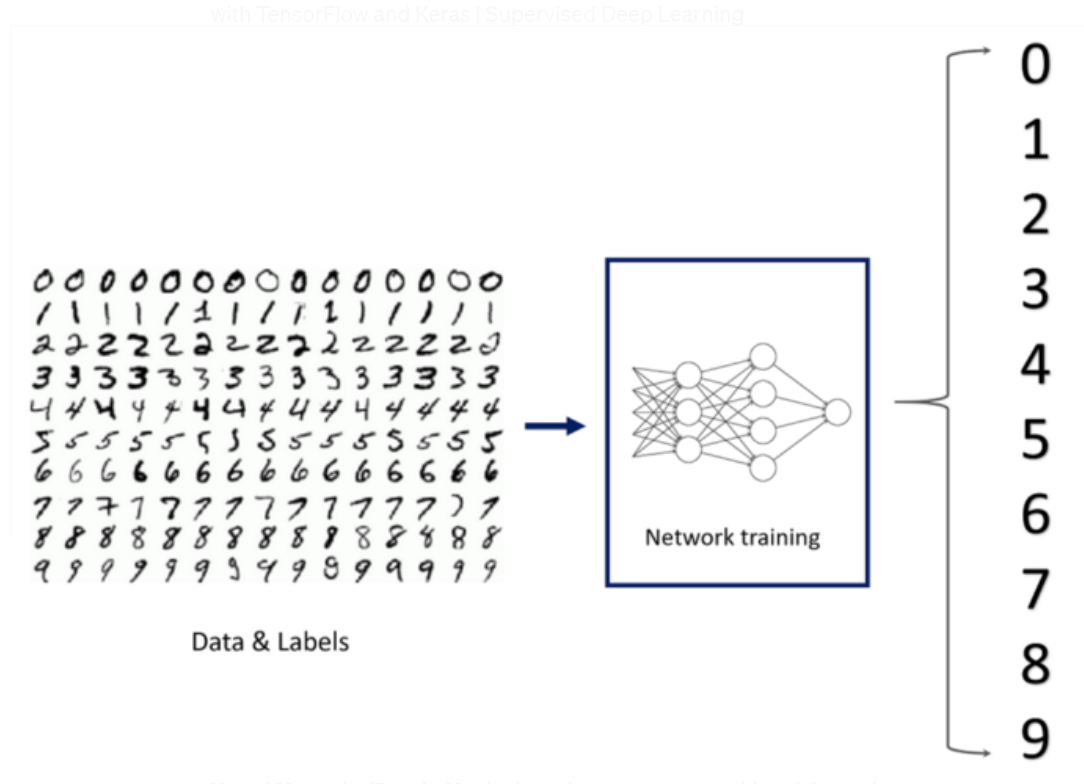

In [5]:
from IPython.display import Image
import os
root_dir = "/gdrive/My Drive/colab/Artificial_Neural_Network(ANN)/과제"
Image(os.path.join(root_dir, "MNIST.PNG"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim

import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

class MNIST(nn.Module):       #nn.Module을 상속
  def __init__(self, config): #생성자 --> 모델에서 사용할 parameter들 layer를 쓸 것을 정의
    super(MNIST, self).__init__()

    # 데이터의 width 길이
    self.width = config["input_width_size"]
    print(self.width, type(self.width))
    # 데이터의 height 길이
    self.height = config["input_height_size"]

    # 과제에서 사용되는 파라미터
    self.feature_size = config["feature_size"]  #과제에서 layer 쌓을때 사용

    # 분류해야 하는 label 수
    self.num_labels = config["num_labels"]

    # 활성화 함수로 Sigmoid 사용
    self.activation = nn.Sigmoid()

    # Neural Network
    self.layer_1 = nn.Linear(in_features=self.width*self.height, out_features = self.feature_size)  #과제 시 사용하는 하나의 레이어(입력벡터 사이즈, 출력벡터 사이즈)
    self.layer_2 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)  #이전 레이어의 아웃풋 크기와 이번 레이어의 인풋 크기를 일치시킬것!!!
    self.layer_3 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_4 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_5 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_6 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_7 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_8 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_9 = nn.Linear(in_features=self.feature_size, out_features = self.feature_size)
    self.layer_10 = nn.Linear(in_features=self.feature_size, out_features = self.num_labels)

  def forward(self, input_features, labels=None):   #데이터 연산과정
    # input_features : [batch, width*heigt]         #batch: 여러개의 데이터를 한번에 입력한 것 ==> 속도가 빨라짐
    layer_1_output = self.layer_1(input_features)          #batch 사용 안하면 loss값이 하나의 데이터에만 치우침.사용해야 일반화 능력이 좋아진다.
    # labels : [batch]                                     데이터는 width*height 모양의 벡터가 width만큼 존재한다.
    # layer_1_output : [batch, num_labels]

    activated_output_1 = self.activation(layer_1_output)  #output에 활성화 함수를 입힌 최종 아웃풋

    # 학습 시
    if labels is not None:
      loss_fnc = nn.CrossEntropyLoss()
      logits = activated_output_1
      loss = loss_fnc(logits, labels)               #logits:모델의 출력값 (2차원), labels: 실제 정답 (1차원)
      return loss
    # 평가 시
    else:
      output = torch.argmax(activated_output_1, -1)
      # [batch]
      return output

#여기까지가 모델, 다음 과정은 전처리

<pre>
<h2> 1. MNIST 데이터를 읽고 train_X, train_y // test_X, test_y에 저장 </h2>
</pre>

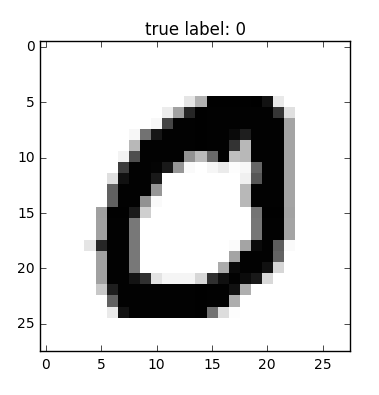

In [7]:
Image(os.path.join(root_dir, "mnist_example.PNG")) #28*28 모양

In [8]:
from keras.datasets import mnist
import torch
def load_dataset():
  (train_X, train_y), (test_X, test_y) = mnist.load_data()  #데이터 가져오기
  print(train_X.shape) #(60000개, 28, 28)
  print(train_y.shape)
  print(test_X.shape) #(10000개, 28, 28)
  print(test_y.shape)
  train_X = train_X.reshape(-1, 28*28)  #reshape(-1,x)는 x 빼고 나머지를 다 앞의 차원으로 몰아줘라. 
                                        # ex) (600, 10, 28, 28) --> (6000, 28*28)
  print(train_X.shape)
  test_X  = test_X.reshape(-1, 28*28)

  train_X = torch.tensor(train_X, dtype=torch.float)    #그냥 텐서 객체를 입혀준 것.
  train_y = torch.tensor(train_y, dtype=torch.long)
  test_X = torch.tensor(test_X, dtype=torch.float)
  test_y = torch.tensor(test_y, dtype=torch.long)
  return (train_X, train_y), (test_X, test_y)
tmp = load_dataset()

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(60000, 784)


In [9]:
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()     #텐서 객체를 다시 리스트 형태로 바꿔준다.

<pre>
<h2> 2. 불러온 데이터를 이용하여 모델 학습 및 평가 </h2>
</pre>

In [10]:
# test 데이터로 모델을 평가하는 함수 
def do_test(model, test_dataloader):
  model.eval()
  predicts, answers = [], []
  for step, batch in enumerate(test_dataloader):
    # .cuda()를 통해 메모리에 업로드
    batch = tuple(t.cuda() for t in batch)

    input_features, labels = batch
    output = model(input_features)

    predicts.extend(tensor2list(output))
    answers.extend(tensor2list(labels))
    
  print("Accuracy : {}".format(accuracy_score(answers, predicts)))

In [11]:
def train(config):
  # 모델 생성
  model = MNIST(config).cuda()

  # 데이터 Load
  (train_X, train_y), (test_X, test_y) = load_dataset()
  
  # TensorDataset/DataLoader를 통해 batch 단위로 데이터를 나누고 Shuffle
  train_features = TensorDataset(train_X, train_y)
  train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])  #섞는 기능, 크기 조절 등 기능이 있는 툴

  test_features = TensorDataset(test_X, test_y)
  test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])

  # 모델을 최적화하기 위한 optimizer 선언
  optimizer = optim.Adam(model.parameters(), lr=0.0001) #lr : learning rate
  model.train()
  for epoch in range(config["epoch"]):
    # epoch 마다 평균 loss를 출력하기위한 loss 저장 리스트
    losses = []

    for step, batch in enumerate(train_dataloader):
      # batch = (train_X[step], train_y[step])  step번째의 data

      # .cuda()를 통해 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)

      # 각 feature 저장
      input_features, labels = batch
      
      # 모델 호출을 통해 loss return
      loss = model(input_features, labels)      #이렇게 썼지만 실제 사용되는 함수는 forward 함수이다.

      # 역전파 변화도 초기화
      # ==> .backward() 호출 시, 변화도 버퍼에 데이터가 계속 누적
      #     이를 초기화 시켜주는 단계
      optimizer.zero_grad()

      # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
      loss.backward()

      # 모델 내부 각 매개변수 가중치 갱신
      optimizer.step()

      if (step+1) % 1000 == 0:
        print("{} step processed.. current loss : {}".format(step+1, loss.data.item())) #loss가 텐서 형태라서 저런식으로 뽑아와야 함
      losses.append(loss.data.item())
    
    print("Average Loss : {}".format(np.mean(losses)))
    # epoch이 끝날 때 마다, 모델 저장
    torch.save(model.state_dict(), os.path.join(config["output_dir_path"], "epoch_{}.pt".format(epoch + 1)))

    # 지금까지 학습한 가중치로 평가 진행
    do_test(model, test_dataloader)
    

def test(config):
  model = MNIST(config).cuda()

  # 저장된 모델 가중치 Load
  model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

  # 데이터 load
  (_, _), (test_X, test_y) = load_dataset()
  
  test_features = TensorDataset(test_X, test_y)
  test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])
  
  do_test(model, test_dataloader)

In [24]:
import os 
if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output_layer10")   #학습된 모델을 저장하는 주소
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "test",                              # train / test 모드 설정
              "trained_model_name":"epoch_{}.pt".format(9),# 저장된 모듈 중 쓰고 싶은 모델의 epoch 값 (몇번 째 반복된 모델을 쓸 것인가?)
              "output_dir_path":output_dir,
              "input_width_size":28,
              "input_height_size":28,
              "feature_size": 512,
              "num_labels": 10,
              "batch_size":32,
              "epoch":10,
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

28 <class 'int'>
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(60000, 784)
Accuracy : 0.2849
